# Sentinel Devices - Anomaly Detection Project

ISYE / CSE / MGT 6748

Student: Tung Nguyen, tnguyen844@gatech.edu

This notebook was run on: Python 3.13, macOS 15 Sequoia, Macbook Pro (M1 Max).

## Distributed Model Training & Synthetic Data
One of the benefits of a Prophet-based forecasting model is the ability to parallelize model training and model inference, which makes use of modern hardware. Instead of training 8 models sequentially as in `00_setup_and_model_training.ipynb`, the models can be trained in parallel. 

This notebook utilizes Python's `multiprocessing` library to accomplish this as a proof-of-concept, however, many production-grade workflow orchestrators and machine-learning software have similar features (Ex. [AWS SageMaker AI](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html), or [Apache Airflow's MappedTask](https://airflow.apache.org/docs/apache-airflow/stable/authoring-and-scheduling/dynamic-task-mapping.html])).

In [37]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet
from functools import partial
from multiprocessing import Pool, cpu_count
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from joblib import dump
from utils import train_prophet_model

analog_sensors = [
    'tp2',
    'tp3',
    'h1',
    'dv_pressure',
    'reservoirs',
    'oil_temperature',
    'flowmeter',
    'motor_current'
]

digital_sensors = [
    'comp',
    'dv_electric',
    'towers',
    'mpg',
    'lps',
    'pressure_switch',
    'oil_level',
    'caudal_impulses'
]

gps_sensors = [
    'gps_long',
    'gps_lat',
    'gps_speed',
    'gps_quality'
]

In [38]:
cpu_count() # Note: you may have less cores

10

## Global Settings

In [39]:
today = datetime(2022, 2, 15, 2, 0, 0) # Simulate "today" as Feb 15th

training_window = 10 # days -- train on shorter timeframe as a Proof of Concept
inference_window = 7 # days

n_signal_threshold = 5
out_of_bounds_buffer = 0.1

event_consolidation_threshold_secs = 10

### Calculated Fields

In [40]:
train_start = (today - timedelta(days=training_window)).strftime(r'%Y-%m-%d %H:%M:%S')
inference_start = (today - timedelta(days=inference_window)).strftime(r'%Y-%m-%d %H:%M:%S')
end = today.strftime(r'%Y-%m-%d %H:%M:%S')

print(f'Train Start: {train_start} - {end}')
print(f'Inference Period: {inference_start} - {end}')

Train Start: 2022-02-05 02:00:00 - 2022-02-15 02:00:00
Inference Period: 2022-02-08 02:00:00 - 2022-02-15 02:00:00


## Parallel Training Example
Proof-of-concept for parallel model training using Python's `multiprocessing` library.

In [17]:
with sqlite3.connect(r'./02-data/data.db') as con:
    df = pd.read_sql(f"""
        select * 
        from train_data
        where 
            failure_id is null
            and '{train_start}' <= ts and ts < '{end}'
    """, con, parse_dates=['ts'])

print(df.shape)

(720010, 23)


In [18]:
%%time
train = partial(train_prophet_model, df=df)

if __name__ == '__main__':
    with Pool(processes=8) as pool:
        _ = pool.map(train, analog_sensors)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
19:54:56 - cmdstanpy - INFO - Chain [1] start processing
19:54:56 - cmdstanpy - INFO - Chain [1] start processing
19:54:56 - cmdstanpy - INFO - Chain [1] start processing
19:54:57 - cmdstanpy - INFO - Chain [1] start processing
19:54:57 - cmdstanpy - INFO - Chain [1] start processing
19:54:57 - cmdstanpy - INFO - Chain [1] start processing
19:54:57 - cmdstanpy - INFO - Chain [1] start processing
19:54:58 - cmdstanpy - INFO - Chain [1] start processing
19:55:09 - cmdstanpy - INFO - Chain [1] done processing
20:02:17 - cmdstanpy - I

CPU times: user 185 ms, sys: 509 ms, total: 693 ms
Wall time: 11min 48s


## Synthetic Anomaly Generation
This dataset does not contain true "labels" as the overarching goal is to predict failures *before* it happens. Thus, this section provides a framework to tune a model via synthetic anomaly generation. 

The idea is to take a section of existing, "normal operation" data and multiply it by a triangular distribution, then train a model to recognize this synthetic anomaly.

This also paves the way for future work to develop methods of generating different types of anomalies, such as modifying the period and/or cadence of fluctuations.

In [ ]:
min_multiplier = 1
max_multiplier = 1.25 # Max 25% increase

n_anomalies = 10
i = 0
output = []
synthetic_df = pd.DataFrame(columns=['row_id', 'multiplier'])

while True:

    # Sample starting timestamp
    # 72_000 seconds is one "operational" day, e.g. 6am to 2am @ 1Hz
    start_ts = np.random.randint(0, 72_000*training_window) # Random sample within 1 month

    # Check if start_ts is within an hour to previously sampled timestamps
    if output:
        for j in output:
            if abs(start_ts - j) <= 60*60:
                continue
    
    # Increment
    i += 1

    # Random event length, between 10 to 30 mins long
    length = np.random.randint(10, 20)*60

    # Triangular distribution
    half = np.linspace(min_multiplier, max_multiplier, int((length - 1)/2))
    full = np.concatenate((half, half[::-1][1:]), axis=0)

    # Save samples
    temp = pd.DataFrame.from_dict({
        'row_id': np.arange(start=start_ts, stop=start_ts + length - 3),
        'multiplier': full
    })
    synthetic_df = (
        pd.concat([temp, synthetic_df])
        if synthetic_df.shape[0] > 0 
        else temp
    )

    output.append(start_ts)

    # Stopping criteria
    if i == n_anomalies:
        break


with sqlite3.connect(r'./02-data/data.db') as con:
    synthetic_df.to_sql(
        name = 'synthetic_anomalies',
        if_exists = 'replace',
        index = False,
        con = con
    )

### Pull Data

In [51]:
with sqlite3.connect(r'./02-data/data.db') as con:
    df = pd.read_sql(f"""
        with
        cte as (
            select *, row_number() over (order by ts asc) as row_id
            from train_data
            where 
                failure_id is null
                and '{train_start}' <= ts and ts < '{end}'
        )
        select c.*, coalesce(a.multiplier, 1) as multiplier
        from cte as c
            left join synthetic_anomalies as a
                on a.row_id = c.row_id
    """, con, parse_dates=['ts'])

print(df.shape)

(720010, 25)


In [52]:
print(f'{(df.multiplier > 1).sum()} secs out of {df.shape[0]} secs are anomalies')
print(f'~{(df.multiplier > 1).sum()/df.shape[0]:.2%} of data points')

8650 secs out of 720010 secs are anomalies
~1.20% of data points


### Plot Data

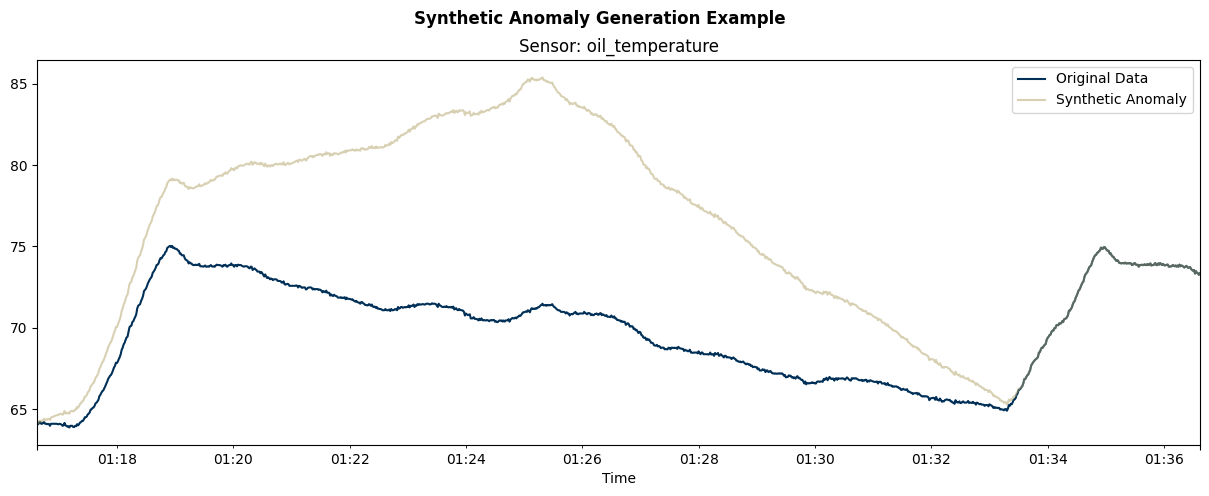

In [36]:
plot_df = df[df.row_id >= df[df.multiplier > 1].iloc[0].row_id].head(20*60).copy(deep=True)
plot_df['oil_temperature_synthetic'] = plot_df['multiplier']*plot_df['oil_temperature']

ax = plot_df.plot(
    x='ts', 
    y=['oil_temperature', 'oil_temperature_synthetic'],
    figsize=(15, 5),
    color=['#003057', '#B3A369'],
    legend=False
);
ax.set_title('Sensor: oil_temperature')
ax.set_xlabel('Time')

for line, alpha in zip(ax.lines, [1., 0.5]):
    line.set_alpha(alpha)

ax.legend()
handles, labels = ax.get_legend_handles_labels()
labels = ['Original Data', 'Synthetic Anomaly']
ax.legend(handles, labels)

plt.suptitle('Synthetic Anomaly Generation Example', fontweight='bold')
plt.show()

## Bayesian Optimization
Proof-of-concept model tuning using Bayesian optimization + the synthetic anomalies generated from the last section.

In [53]:
def build_model(params: dict) -> Prophet:

    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'], 
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    for digital_sensor in [
            'comp',
            'dv_electric',
            'towers',
            'mpg',
            'lps',
            'pressure_switch',
            'oil_level',
            'caudal_impulses'
        ]:
        if params[f'regressor_{digital_sensor}']:
            model.add_regressor(digital_sensor)

    for d in [
            {'name': 'seasonality_30min',  'period': 30*60,    'fourier_order': 4},
            {'name': 'seasonality_01hour', 'period': 60*60,    'fourier_order': 6},
            {'name': 'seasonality_05hour', 'period': 60*60*5,  'fourier_order': 8},
            {'name': 'seasonality_10hour', 'period': 60*60*10, 'fourier_order': 10},
            {'name': 'seasonality_15hour', 'period': 60*60*15, 'fourier_order': 12},
            {'name': 'seasonality_daily',  'period': 60*60*20, 'fourier_order': 14},
        ]:
        if params[d['name']]:
            model.add_seasonality(
                name = d['name'], 
                period = d['period'], 
                fourier_order = d['fourier_order']    
            )

    return model


def objective(params: dict, sensor: str, df: pd.DataFrame, batch_size: int = 750_000) -> float:
    
    # Build & Train Model
    model = build_model(params)
    df['y'] = df['multiplier']*df[sensor]
    model.fit(df.rename(columns={'ts': 'ds'}))

    # Predict
    tp = 0
    fp = 0
    for start in range(0, len(df), batch_size):
        chunk = df.iloc[start:start + batch_size]

        pred_df = (
            model
                .predict(chunk.rename(columns={'ts': 'ds'}))
                .merge(chunk, left_on='ds', right_on='ts')
        )

        pred_df['range'] = pred_df['yhat_upper'] - pred_df['yhat_lower']
        pred_df['range_expanded'] = pred_df['range'] * (1 + out_of_bounds_buffer)
        pred_df['yhat_upper_expanded'] = pred_df['yhat'] + pred_df['range_expanded'] / 2
        pred_df['yhat_lower_expanded'] = pred_df['yhat'] - pred_df['range_expanded'] / 2

        pred_df['y_pred'] = (
            (pred_df['y'] > pred_df['yhat_upper_expanded']) |
            (pred_df['y'] < pred_df['yhat_lower_expanded'])
        ).astype(int)
        
        pred_df['y_true'] = (pred_df['multiplier'] > 1).astype(int)

        tp += ((pred_df['y_true'] == 1) & (pred_df['y_pred'] == 1)).sum()
        fp += ((pred_df['y_true'] == 0) & (pred_df['y_pred'] == 1)).sum()

    # Score
    precision = tp / (tp + fp)

    # Log
    with open(f'./output/train_{sensor}.log', 'a') as f:
        f.write(f'{precision}, {params}\n')

    return {'loss': -precision, 'status': STATUS_OK, 'model': model}

In [54]:
regressors = {
    f'regressor_{sensor}': hp.choice(f'regressor_{sensor}', [True, False])
    for sensor in digital_sensors
}

seasonalities = {
    seasonality: hp.choice(seasonality, [True, False])
    for seasonality in [
        'seasonality_30min',
        'seasonality_01hour',
        'seasonality_05hour',
        'seasonality_10hour',
        'seasonality_15hour',
        'seasonality_daily'
    ]
}

space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.01, 1.0),
    **regressors,
    **seasonalities
}

display(space) # Display search space

# Tune for sensor = oil_temperature as a proof-of-concept
f_objective = partial(objective, df=df, sensor='oil_temperature')

trials = Trials()
best = fmin(
    fn = f_objective, 
    space = space, 
    early_stop_fn = no_progress_loss(10), 
    max_evals = 100, 
    rstate = np.random.default_rng(1), 
    algo = tpe.suggest, 
    trials = trials
)

{'changepoint_prior_scale': <hyperopt.pyll.base.Apply at 0x531a3e950>,
 'regressor_comp': <hyperopt.pyll.base.Apply at 0x408f594d0>,
 'regressor_dv_electric': <hyperopt.pyll.base.Apply at 0x408f593d0>,
 'regressor_towers': <hyperopt.pyll.base.Apply at 0x408f5a7d0>,
 'regressor_mpg': <hyperopt.pyll.base.Apply at 0x408f5a350>,
 'regressor_lps': <hyperopt.pyll.base.Apply at 0x408f581d0>,
 'regressor_pressure_switch': <hyperopt.pyll.base.Apply at 0x408f5b2d0>,
 'regressor_oil_level': <hyperopt.pyll.base.Apply at 0x408f5add0>,
 'regressor_caudal_impulses': <hyperopt.pyll.base.Apply at 0x408f58d50>,
 'seasonality_30min': <hyperopt.pyll.base.Apply at 0x408f58ed0>,
 'seasonality_01hour': <hyperopt.pyll.base.Apply at 0x408f58350>,
 'seasonality_05hour': <hyperopt.pyll.base.Apply at 0x408f587d0>,
 'seasonality_10hour': <hyperopt.pyll.base.Apply at 0x408f5aa50>,
 'seasonality_15hour': <hyperopt.pyll.base.Apply at 0x408f59ed0>,
 'seasonality_daily': <hyperopt.pyll.base.Apply at 0x443aafad0>}

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

09:21:32 - cmdstanpy - INFO - Chain [1] start processing

09:32:41 - cmdstanpy - INFO - Chain [1] done processing



  1%|          | 1/100 [13:21<22:01:53, 801.15s/trial, best loss: -0.030614404537662173]

09:34:29 - cmdstanpy - INFO - Chain [1] start processing

09:43:38 - cmdstanpy - INFO - Chain [1] done processing



  2%|▏         | 2/100 [24:15<19:27:08, 714.57s/trial, best loss: -0.030614404537662173]

09:45:21 - cmdstanpy - INFO - Chain [1] start processing

09:52:44 - cmdstanpy - INFO - Chain [1] done processing



  3%|▎         | 3/100 [33:17<17:07:46, 635.74s/trial, best loss: -0.030614404537662173]

09:54:09 - cmdstanpy - INFO - Chain [1] start processing

09:59:26 - cmdstanpy - INFO - Chain [1] done processing



  4%|▍         | 4/100 [39:58<14:29:03, 543.16s/trial, best loss: -0.030614404537662173]

10:00:47 - cmdstanpy - INFO - Chain [1] start processing

10:07:55 - cmdstanpy - INFO - Chain [1] done processing



  5%|▌         | 5/100 [48:27<14:00:32, 530.87s/trial, best loss: -0.030614404537662173]

10:09:43 - cmdstanpy - INFO - Chain [1] start processing

10:18:08 - cmdstanpy - INFO - Chain [1] done processing



  6%|▌         | 6/100 [58:40<14:35:46, 559.00s/trial, best loss: -0.030614404537662173]

10:19:36 - cmdstanpy - INFO - Chain [1] start processing

10:29:10 - cmdstanpy - INFO - Chain [1] done processing



  7%|▋         | 7/100 [1:09:42<15:18:13, 592.40s/trial, best loss: -0.030614404537662173]

10:31:07 - cmdstanpy - INFO - Chain [1] start processing

10:42:42 - cmdstanpy - INFO - Chain [1] done processing



  8%|▊         | 8/100 [1:23:16<16:56:52, 663.18s/trial, best loss: -0.030614404537662173]

10:44:31 - cmdstanpy - INFO - Chain [1] start processing

10:57:29 - cmdstanpy - INFO - Chain [1] done processing



  9%|▉         | 9/100 [1:38:01<18:30:59, 732.52s/trial, best loss: -0.030614404537662173]

10:59:02 - cmdstanpy - INFO - Chain [1] start processing

11:09:42 - cmdstanpy - INFO - Chain [1] done processing



 10%|█         | 10/100 [1:50:14<16:32:07, 661.41s/trial, best loss: -0.030614404537662173]


In [55]:
best

{'changepoint_prior_scale': np.float64(0.808609146056219),
 'regressor_caudal_impulses': np.int64(1),
 'regressor_comp': np.int64(0),
 'regressor_dv_electric': np.int64(1),
 'regressor_lps': np.int64(0),
 'regressor_mpg': np.int64(0),
 'regressor_oil_level': np.int64(0),
 'regressor_pressure_switch': np.int64(0),
 'regressor_towers': np.int64(1),
 'seasonality_01hour': np.int64(1),
 'seasonality_05hour': np.int64(0),
 'seasonality_10hour': np.int64(0),
 'seasonality_15hour': np.int64(0),
 'seasonality_30min': np.int64(1),
 'seasonality_daily': np.int64(0)}

In [56]:
model = build_model(best)
model.fit(df.rename(columns={'ts': 'ds'}))

dump(model, f'03-models/best_model_oil_temperature.joblib')

11:11:00 - cmdstanpy - INFO - Chain [1] start processing

11:17:24 - cmdstanpy - INFO - Chain [1] done processing



['03-models/best_model_oil_temperature.joblib']